In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import the required libraries
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [ ]:
#defining  important the attributes
IMAGE_SIZE=224
CHANNELS=3
BATCH_SIZE=32
EPOCHS=30
dataset = '/content/drive/MyDrive/ds/augmented_dataset/'
best_ResNet_epoch = '/content/drive/MyDrive/ResNet/best_epoch/'

In [ ]:
# verify classes are balanced
def count_images(directory):
    image_count = 0
    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        if os.path.isfile(img_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_count += 1
    return image_count

# Loop through each class (subdirectory) in the dataset directory
for subdir in os.listdir(dataset):
    class_dir = os.path.join(dataset, subdir)

    # Check if it's a directory
    if os.path.isdir(class_dir):
        # Count the number of images in this class directory
        image_count = count_images(class_dir)
        print(f"Class {subdir}: {image_count} images")
    else:
        print(f"{subdir} is not a directory.")

Class buildings: 210 images
Class river: 210 images
Class overpass: 210 images
Class baseballdiamond: 210 images
Class freeway: 210 images
Class sparseresidential: 210 images
Class golfcourse: 210 images
Class harbor: 210 images
Class mobilehomepark: 210 images
Class storagetanks: 210 images
Class beach: 210 images
Class agricultural: 210 images
Class airplane: 210 images
Class chaparral: 210 images
Class runway: 210 images
Class denseresidential: 210 images
Class tenniscourt: 210 images
Class forest: 210 images
Class parkinglot: 210 images
Class intersection: 210 images
Class mediumresidential: 210 images


In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/ds/augmented_dataset/',
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4410 files belonging to 21 classes.


In [ ]:
landuse_class_names = dataset.class_names
landuse_class_names

['agricultural',
 'airplane',
 'baseballdiamond',
 'beach',
 'buildings',
 'chaparral',
 'denseresidential',
 'forest',
 'freeway',
 'golfcourse',
 'harbor',
 'intersection',
 'mediumresidential',
 'mobilehomepark',
 'overpass',
 'parkinglot',
 'river',
 'runway',
 'sparseresidential',
 'storagetanks',
 'tenniscourt']

In [ ]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)

(224, 224, 3)


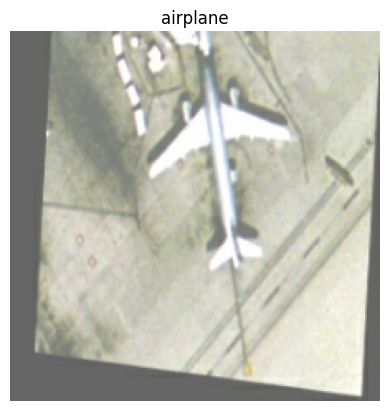

In [ ]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(landuse_class_names[label_batch[0]])
    plt.axis("off")

In [ ]:
# Extract class names from the dataset
class_names = dataset.class_names

# Prepare to display one image per class
plt.figure(figsize=(15, 15))

# Dictionary to store the first image path per class
class_first_image_paths = {}

# Iterate over the dataset to find and display the first image from each class
for images, labels in dataset:
    for image, label in zip(images, labels):
        class_name = class_names[label.numpy()]  # Get the class name from the label
        if class_name not in class_first_image_paths:
            # Store the path of the first image encountered for this class
            class_first_image_paths[class_name] = image
            # Display the first image found for this class
            plt.subplot(5, 5, len(class_first_image_paths))  # Adjust subplot position dynamically
            plt.imshow(image.numpy().astype("uint8"))
            plt.title(class_name)
            plt.axis("off")

        # Break loop if we have found one image per class
        if len(class_first_image_paths) == len(class_names):
            break

    # Break outer loop if we have found one image per class
    if len(class_first_image_paths) == len(class_names):
        break

plt.tight_layout()  # Adjust subplot layout to prevent overlap
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# function to split DS
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.2 ,test_split=0.1, shuffle=True, shuffle_size=10000):

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_data_s = ds.take(train_size)
    val_data_s = ds.skip(train_size).take(val_size)
    test_data_s = ds.skip(train_size).skip(val_size)

    return train_data_s, val_data_s, test_data_s

train_data_s, val_data_s, test_data_s = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_data_s)

96

In [ ]:
len(val_data_s)

27

In [ ]:
len(test_data_s)

15

In [ ]:
train_data_s = train_data_s.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data_s = val_data_s.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data_s = test_data_s.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
     layers.experimental.preprocessing.Rescaling(1.0/255)
]
)

**RESNET50 ARCHITECTURE**

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Add, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform

BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS = 3
n_classes = 21

def resize_and_rescale(image):
    # Resize the image to IMAGE_SIZE x IMAGE_SIZE
    resized_image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    # Rescale pixel values to [0,1]
    return resized_image / 255.0

def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure

    Parameters
    ----------
    X : tensor
        input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f : integer
        specifying the shape of the middle CONV's window for the main path
    filters : list
        python list of integers, defining the number of filters in the CONV layers of the main path
    stage : integer
        used to name the layers, depending on their position in the network
    block : str
        used to name the layers, depending on their position in the network

    Returns
    -------
    X : tensor
        output of the identity block, tensor of shape (n_H, n_W, n_C)
    """

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. we'll need this later to add back to the main path.
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid',
               name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same',
               name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid',
               name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

def convolutional_block(X, f, filters, stage, block, s=2):
    """
    Implementation of the convolutional block as defined in Figure

    Parameters
    ----------
    X : tensor
        input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f : integer
        specifying the shape of the middle CONV's window for the main path
    filters : list
        python list of integers, defining the number of filters in the CONV layers of the main path
    stage : integer
        used to name the layers, depending on their position in the network
    block : str
        used to name the layers, depending on their position in the network
    s : integer, optional
        Integer, specifying the stride to be used. The default is 2.

    Returns
    -------
    X : tensor
        output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

def ResNet50(input_shape, outputClasses):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Parameters
    ----------
    input_shape : tuple, optional
        shape of the input image.
    outputClasses : integer, optional
        number of classes.

    Returns
    -------
    model : object
        a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Resize and rescale the input image
    X = resize_and_rescale(X_input)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    # output layer
    X = Flatten()(X)
    X = Dense(outputClasses, activation='softmax', name='fc' + str(outputClasses),
              kernel_initializer=glorot_uniform(seed=0))(X)

    # Create model
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

# Define the ResNet50 model
# model = ResNet50(input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS), outputClasses=n_classes)
model = ResNet50(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), outputClasses=n_classes)

# Print model summary
model.summary()


Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 tf.image.resize (TFOpLambd  (None, 224, 224, 3)          0         ['input_1[0][0]']             
 a)                                                                                               
                                                                                                  
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)          0         ['tf.image.resize[0][0]']     
 a)                                                                                               
                                                                                           

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_data_s,
    epochs=50,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_data_s
)

Epoch 1/50
96/96 [==============================] - 258s 216ms/step - loss: 9.6511 - accuracy: 0.0551 - val_loss: 19.0845 - val_accuracy: 0.0671
Epoch 2/50
96/96 [==============================] - 12s 121ms/step - loss: 3.3296 - accuracy: 0.0678 - val_loss: 3.3457 - val_accuracy: 0.0637
Epoch 3/50
96/96 [==============================] - 12s 121ms/step - loss: 2.8511 - accuracy: 0.1370 - val_loss: 2.9901 - val_accuracy: 0.1308
Epoch 4/50
96/96 [==============================] - 12s 121ms/step - loss: 2.6060 - accuracy: 0.2166 - val_loss: 2.9655 - val_accuracy: 0.1447
Epoch 5/50
96/96 [==============================] - 12s 121ms/step - loss: 2.3969 - accuracy: 0.2671 - val_loss: 69.5198 - val_accuracy: 0.1250
Epoch 6/50
96/96 [==============================] - 12s 121ms/step - loss: 2.1644 - accuracy: 0.3402 - val_loss: 2.5568 - val_accuracy: 0.3530
Epoch 7/50
96/96 [==============================] - 12s 121ms/step - loss: 1.8989 - accuracy: 0.4126 - val_loss: 2.3916 - val_accuracy: 0.3

In [ ]:
import datetime

currentDT = datetime.datetime.now()
print(currentDT);
model_version="RESNET-V1"
model.save(f"/content/drive/MyDrive/ResNet/versions/{model_version}")

2024-04-18 08:35:31.782122


In [ ]:
scores = model.evaluate(test_data_s)
scores

15/15 [==============================] - 7s 39ms/step - loss: 0.9975 - accuracy: 0.8771


[0.9974517822265625, 0.8770833611488342]

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 96}

In [ ]:
history.history['accuracy']

[0.05512067675590515,
 0.06784083694219589,
 0.13698630034923553,
 0.21656881272792816,
 0.267123281955719,
 0.34018266201019287,
 0.4125896990299225,
 0.4869536757469177,
 0.5479452013969421,
 0.6301369667053223,
 0.6826484203338623,
 0.7596216797828674,
 0.8147423267364502,
 0.8652967810630798,
 0.8998695611953735,
 0.917155921459198,
 0.9246575236320496,
 0.9230267405509949,
 0.9540117383003235,
 0.9670580625534058,
 0.9504240155220032,
 0.9425961971282959,
 0.9393346309661865,
 0.946183979511261,
 0.9732550382614136,
 0.9575994610786438,
 0.966079592704773,
 0.9784736037254333,
 0.9882583022117615,
 0.9840182662010193,
 0.9814090132713318,
 0.9693411588668823,
 0.9680365324020386,
 0.9585779309272766,
 0.8897586464881897,
 0.9298760890960693,
 0.9686888456344604,
 0.9833659529685974,
 0.9892367720603943,
 0.9924983978271484,
 0.9944553375244141,
 0.9911937117576599,
 0.9944553375244141,
 0.9970645904541016,
 0.9990215301513672,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [ ]:
acc=history.history['accuracy']
vali_acc=history.history['val_accuracy']
loss=history.history['loss']
vali_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation loss')

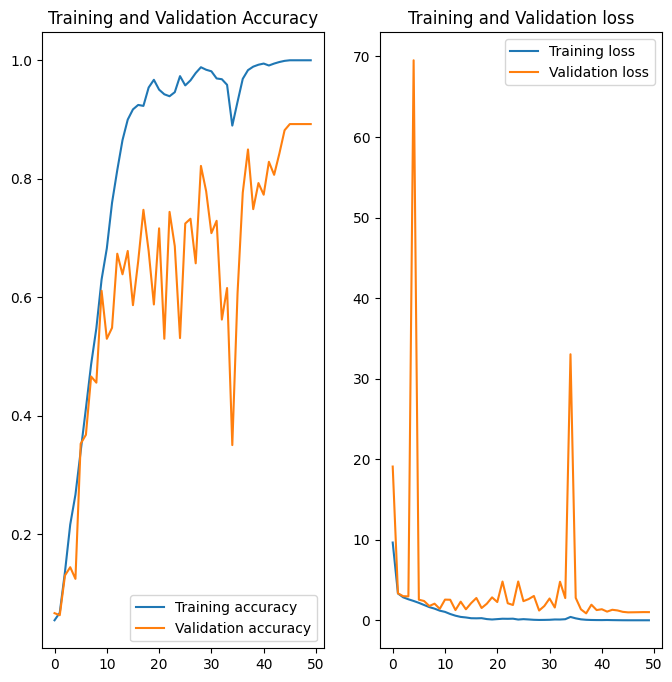

In [ ]:
EPOCHS=50
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training accuracy')
plt.plot(range(EPOCHS), vali_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training loss')
plt.plot(range(EPOCHS), vali_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')

first image to predict
actual label:  baseballdiamond
1/1 [==============================] - 1s 1s/step
predicted label: baseballdiamond


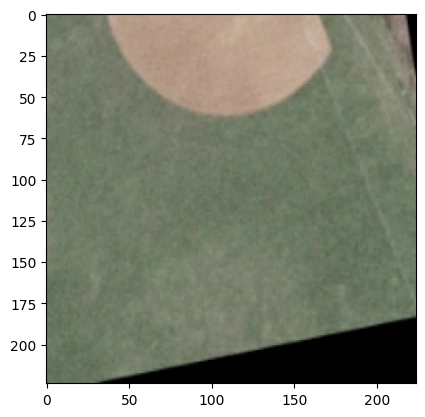

In [ ]:
for images_batch, labels_batch in test_data_s.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label= labels_batch [0].numpy()

    print("first image to predict")
    plt.imshow(first_image)

    print("actual label: ",landuse_class_names[first_label])
    batch_prediction=model.predict(images_batch)
    print("predicted label:",landuse_class_names[numpy.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):

    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions=model.predict(img_array)

    predicted_class= landuse_class_names[numpy.argmax(predictions[0])]
    confidence = round(100*(numpy.max(predictions[0])), 2)

    return predicted_class, confidence

1/1 [==============================] - 0s 25ms/step


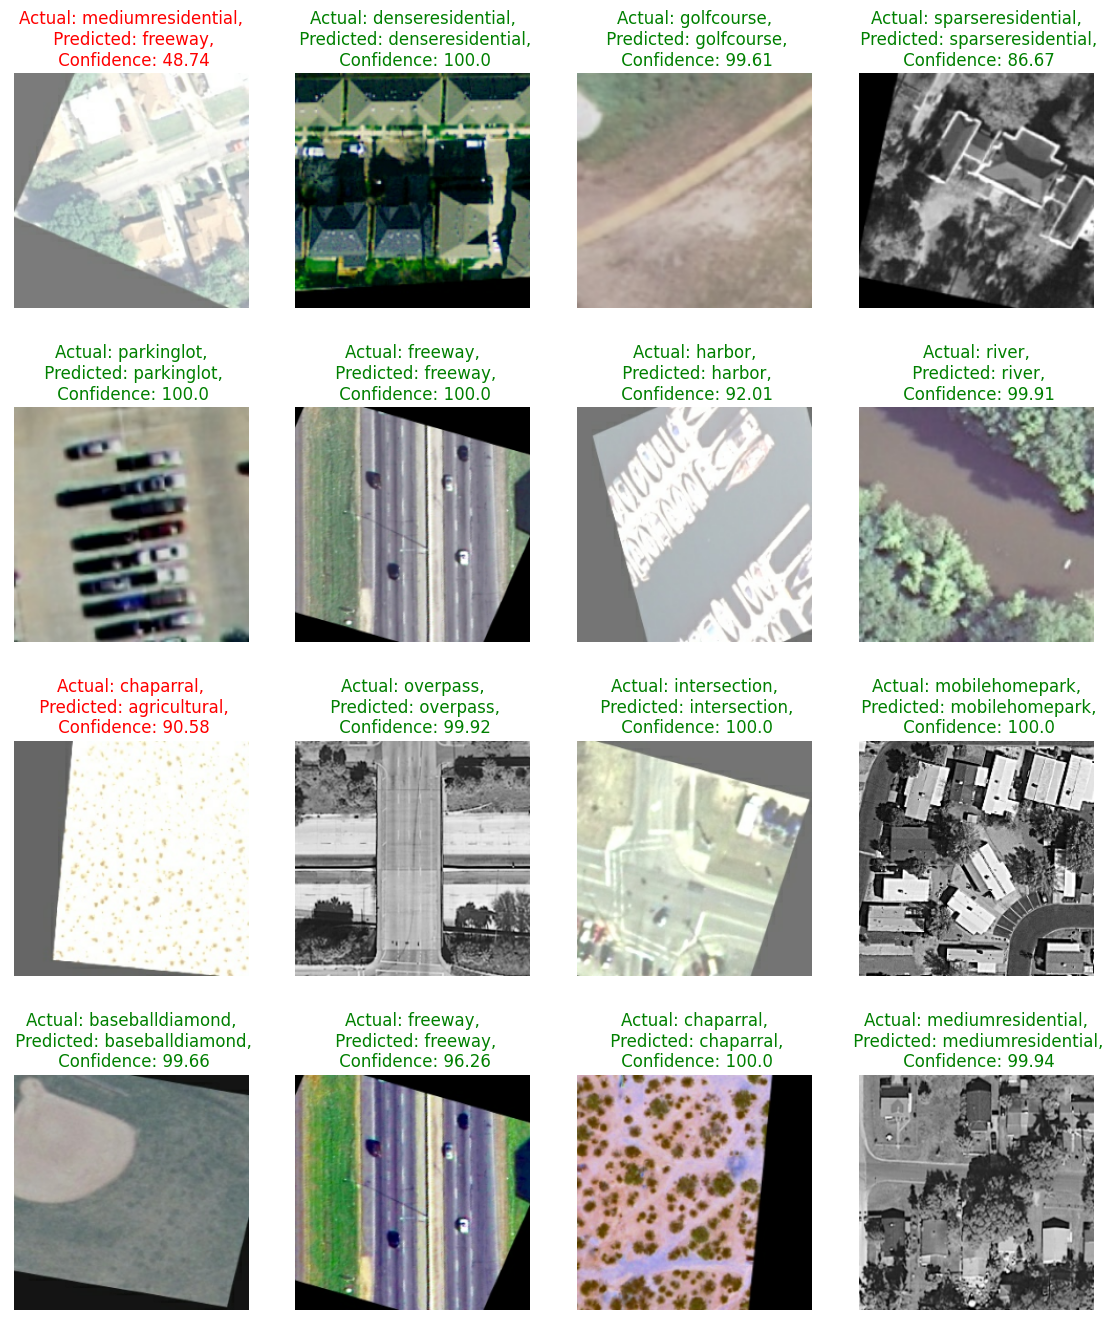

In [ ]:
plt.figure(figsize=(16, 16))
for images, labels in test_data_s.take(1):

    for i in range(16) :

        ax = plt.subplot(4, 4, i+1)
        plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class= landuse_class_names[labels[i]]

        # plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}")
        if actual_class == predicted_class:
            plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}", color='green')
        else:
            plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}", color='red')

        plt.axis("off")

In [ ]:
!pip install seaborn

1/1 [==============================] - 0s 26ms/step


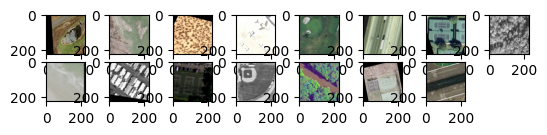

In [ ]:
y_pred = []
y_true = []
for images, labels in test_data_s:

    for i in range(len(test_data_s)) :

        ax = plt.subplot(8, 8, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class=landuse_class_names[labels[i]]
        y_pred.append(predicted_class)
        y_true.append(actual_class)

In [ ]:
y_true

['chaparral',
 'airplane',
 'intersection',
 'runway',
 'intersection',
 'tenniscourt',
 'sparseresidential',
 'agricultural',
 'runway',
 'storagetanks',
 'river',
 'river',
 'airplane',
 'harbor',
 'golfcourse',
 'chaparral',
 'river',
 'mobilehomepark',
 'intersection',
 'runway',
 'river',
 'agricultural',
 'storagetanks',
 'intersection',
 'mobilehomepark',
 'harbor',
 'denseresidential',
 'denseresidential',
 'parkinglot',
 'overpass',
 'harbor',
 'golfcourse',
 'freeway',
 'beach',
 'forest',
 'tenniscourt',
 'parkinglot',
 'storagetanks',
 'beach',
 'buildings',
 'golfcourse',
 'harbor',
 'runway',
 'forest',
 'denseresidential',
 'mediumresidential',
 'sparseresidential',
 'sparseresidential',
 'airplane',
 'harbor',
 'agricultural',
 'freeway',
 'runway',
 'runway',
 'tenniscourt',
 'runway',
 'chaparral',
 'beach',
 'intersection',
 'buildings',
 'airplane',
 'airplane',
 'river',
 'harbor',
 'agricultural',
 'storagetanks',
 'chaparral',
 'parkinglot',
 'beach',
 'runway',


In [ ]:
y_pred

['chaparral',
 'airplane',
 'intersection',
 'runway',
 'intersection',
 'tenniscourt',
 'sparseresidential',
 'agricultural',
 'beach',
 'storagetanks',
 'river',
 'river',
 'airplane',
 'harbor',
 'golfcourse',
 'chaparral',
 'river',
 'mobilehomepark',
 'intersection',
 'freeway',
 'beach',
 'agricultural',
 'storagetanks',
 'golfcourse',
 'mobilehomepark',
 'harbor',
 'denseresidential',
 'denseresidential',
 'parkinglot',
 'overpass',
 'harbor',
 'beach',
 'overpass',
 'beach',
 'forest',
 'tenniscourt',
 'parkinglot',
 'storagetanks',
 'beach',
 'buildings',
 'golfcourse',
 'harbor',
 'runway',
 'forest',
 'denseresidential',
 'mediumresidential',
 'overpass',
 'sparseresidential',
 'airplane',
 'harbor',
 'agricultural',
 'freeway',
 'runway',
 'runway',
 'tenniscourt',
 'mediumresidential',
 'chaparral',
 'beach',
 'intersection',
 'buildings',
 'airplane',
 'airplane',
 'golfcourse',
 'harbor',
 'agricultural',
 'airplane',
 'chaparral',
 'parkinglot',
 'beach',
 'golfcourse',

Text(50.72222222222221, 0.5, 'True labels')

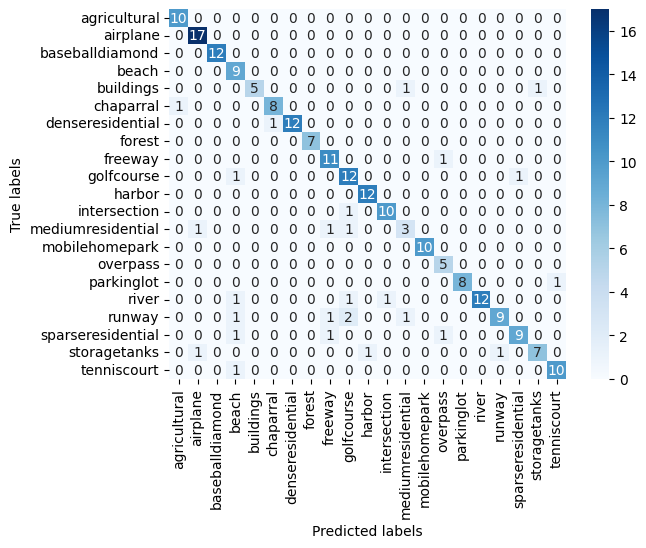

In [ ]:
# confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# assume y_true and y_pred are the true labels and predicted labels, respectively
cm = confusion_matrix(y_true, y_pred)

# define class names
landuse_class_names =['agricultural',
 'airplane',
 'baseballdiamond',
 'beach',
 'buildings',
 'chaparral',
 'denseresidential',
 'forest',
 'freeway',
 'golfcourse',
 'harbor',
 'intersection',
 'mediumresidential',
 'mobilehomepark',
 'overpass',
 'parkinglot',
 'river',
 'runway',
 'sparseresidential',
 'storagetanks',
 'tenniscourt']
# create heatmap with labeled axes
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# set labels
plt.xlabel('Predicted labels')
plt.ylabel('True labels')


In [ ]:
cm

array([[10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 0, 17,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 0,  0, 12,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 0,  0,  0,  9,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  5,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,
         0,  0,  0,  1,  0],
       [ 1,  0,  0,  0,  0,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1, 12,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  7,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 11,  0,  0,  0,  0,  0,  1,  0,
         0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0, 12,  0,  0,  0,  0,  0,  0,
         0,  0,  1,

In [ ]:
num_classes = 21  # classes
precision = []
recall = []

for i in range(num_classes):
    tp = cm[i, i]  # True positives for class i
    fp = sum(cm[:, i]) - tp  # False positives for class i
    fn = sum(cm[i, :]) - tp  # False negatives for class i

    # Calculate precision (p) and recall (r) for class i
    p = tp / (tp + fp) if (tp + fp) > 0 else 0.0  # Handle division by zero
    r = tp / (tp + fn) if (tp + fn) > 0 else 0.0  # Handle division by zero

    # Append precision and recall to respective lists
    precision.append(p)
    recall.append(r)

print("Precision:", precision)
print("Recall:", recall)


Precision: [0.9090909090909091, 0.8947368421052632, 1.0, 0.6428571428571429, 1.0, 0.8888888888888888, 1.0, 1.0, 0.7857142857142857, 0.7058823529411765, 0.9230769230769231, 0.9090909090909091, 0.6, 1.0, 0.7142857142857143, 1.0, 1.0, 0.9, 0.9, 0.875, 0.9090909090909091]
Recall: [1.0, 1.0, 1.0, 1.0, 0.7142857142857143, 0.8888888888888888, 0.9230769230769231, 1.0, 0.9166666666666666, 0.8571428571428571, 1.0, 0.9090909090909091, 0.5, 1.0, 1.0, 0.8888888888888888, 0.8, 0.6428571428571429, 0.75, 0.7, 0.9090909090909091]


In [ ]:
# calculate precision and recall for each class
num_classes = 4
precision = []
recall = []
for i in range(num_classes):
    tp = cm[i, i]
    fp = sum(cm[:, i]) - tp
    fn = sum(cm[i, :]) - tp
    p = tp / (tp + fp)
    r = tp / (tp + fn)
    precision.append(p)
    recall.append(r)

print("Precision:", precision)
print("Recall:", recall)


Precision: [0.9090909090909091, 0.8947368421052632, 1.0, 0.6428571428571429]
Recall: [1.0, 1.0, 1.0, 1.0]


In [ ]:
from sklearn.metrics import f1_score

# Calculate the F1 score
f1 = f1_score(y_true, y_pred, average='weighted')


In [ ]:
from sklearn.metrics import classification_report

# get the classification report, which includes F1 score for each class
report = classification_report(y_true, y_pred)

# print the classification report
print(report)


                   precision    recall  f1-score   support

     agricultural       0.91      1.00      0.95        10
         airplane       0.89      1.00      0.94        17
  baseballdiamond       1.00      1.00      1.00        12
            beach       0.64      1.00      0.78         9
        buildings       1.00      0.71      0.83         7
        chaparral       0.89      0.89      0.89         9
 denseresidential       1.00      0.92      0.96        13
           forest       1.00      1.00      1.00         7
          freeway       0.79      0.92      0.85        12
       golfcourse       0.71      0.86      0.77        14
           harbor       0.92      1.00      0.96        12
     intersection       0.91      0.91      0.91        11
mediumresidential       0.60      0.50      0.55         6
   mobilehomepark       1.00      1.00      1.00        10
         overpass       0.71      1.00      0.83         5
       parkinglot       1.00      0.89      0.94       

**SAVING MODEL**

In [ ]:
import os
from tensorflow.keras.models import load_model

# Assuming 'model' is your Keras model object
save_path = '/content/drive/MyDrive/ResNet/models/RESNET.h5'
model.save(save_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**EXPLAINABILITY FOR LIME**

In [ ]:
! pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=1ccde89440082da4bd8b5c02871cd365d038ce60bb432fea1229d227799813f3
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


**sample IMG for lime**

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


for images_batch, labels_batch in test_data_s.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label= labels_batch [0].numpy()

    print("first image to predict")
    plt.imshow(first_image)

    print("actual label: ",landuse_class_names[first_label])
    batch_prediction=model.predict(images_batch)
    print("predicted label:",landuse_class_names[np.argmax(batch_prediction[0])])





In [ ]:
import numpy as np
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Generate the LIME explanation
explainer = lime_image.LimeImageExplainer()

# Define a predict_proba function for your model
def predict_proba(images):
    # Make predictions with your model
    preds = model.predict(images)
    # Ensure that predictions are in the form of probabilities
    probs = tf.nn.softmax(preds).numpy()
    # Return the predicted probabilities
    return probs

def my_explain_instance(image):
    # Generate an explanation for the test image
    explanation = explainer.explain_instance(
        image,
        predict_proba,
        top_labels=21,  # Specify the number of top labels to consider
        num_samples=1000
    )

    # Show the explanations for top labels
    for label in explanation.top_labels:
        print('Explanation for label:', label)
        temp, mask = explanation.get_image_and_mask(
            label,
            positive_only=True,
            num_features=5,  # Adjust this parameter as needed
            hide_rest=False
        )
        # Display the image and its explanation
        plt.imshow(mark_boundaries(temp, mask))
        plt.show()

# Example usage
my_explain_instance(first_image)


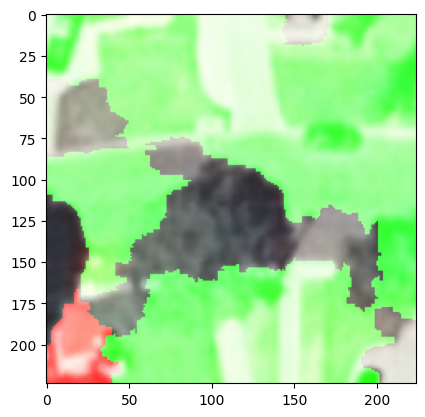

In [ ]:
# Visualize the resulting explanation
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Get the image and explanation as numpy arrays
image, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=20, hide_rest=False)
plt.imshow(image)

**SHAPLEY ADDIDITIVE EXPLAINABLILITY**

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 8.8 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

def get_image_for_prediction(dataset, class_names, image_size=(224, 224)):
    # Get the first image and label from the dataset
    for images_batch, labels_batch in dataset.take(1):
        first_image = images_batch[0].numpy().astype('uint8')
        first_label = labels_batch[0].numpy()

        # Display the image and print the actual label
        plt.imshow(first_image)
        plt.show()
        print("Actual label:", landuse_class_names[first_label])

        # Preprocess the image for model input
        image = tf.image.convert_image_dtype(first_image, tf.float32)
        image = tf.image.resize_with_pad(image, target_height=image_size[0], target_width=image_size[1])
        image = tf.expand_dims(image, axis=0)  # Add batch dimension

        return image



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

landuse_class_names = dataset.class_names

images_array = []  # Array to store the images

for images_batch, labels_batch in test_data_s.take(1):
    for i in range(20):  # Modify the range to specify the number of images you want
        image = images_batch[i].numpy().astype('uint8')
        label = labels_batch[i].numpy()

        print("Image to predict:", i+1)
        plt.imshow(image)
        plt.show()

        print("Actual label:", landuse_class_names[label])
        batch_prediction = model.predict(np.expand_dims(images_batch[i], axis=0))
        predicted_label = landuse_class_names[np.argmax(batch_prediction)]

        print("Predicted label:", predicted_label)
        images_array.append(image)

# 20 images in array


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import shap
shap.initjs()
print(first_image.shape)
masker = shap.maskers.Image("inpaint_telea", first_image.shape)

explainer = shap.Explainer(model, masker, output_names=landuse_class_names)

explainer

(224, 224, 3)


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   5%|▌         | 1/20 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  15%|█▌        | 3/20 [00:39<02:22,  8.38s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 4/20 [00:57<03:14, 12.17s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██▌       | 5/20 [01:19<03:56, 15.80s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███       | 6/20 [01:37<03:52, 16.58s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  35%|███▌      | 7/20 [01:55<03:40, 16.99s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|████      | 8/20 [02:10<03:17, 16.44s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  45%|████▌     | 9/20 [02:30<03:14, 17.69s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 10/20 [02:52<03:10, 19.00s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  55%|█████▌    | 11/20 [03:20<03:13, 21.55s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 12/20 [03:40<02:50, 21.33s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  65%|██████▌   | 13/20 [04:03<02:31, 21.64s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|███████   | 14/20 [04:25<02:10, 21.81s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████▌  | 15/20 [04:43<01:42, 20.57s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 16/20 [05:03<01:21, 20.40s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  85%|████████▌ | 17/20 [05:21<00:59, 19.86s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|█████████ | 18/20 [05:40<00:39, 19.64s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  95%|█████████▌| 19/20 [06:00<00:19, 19.53s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 20/20 [06:22<00:00, 20.39s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 21it [06:40, 20.01s/it]


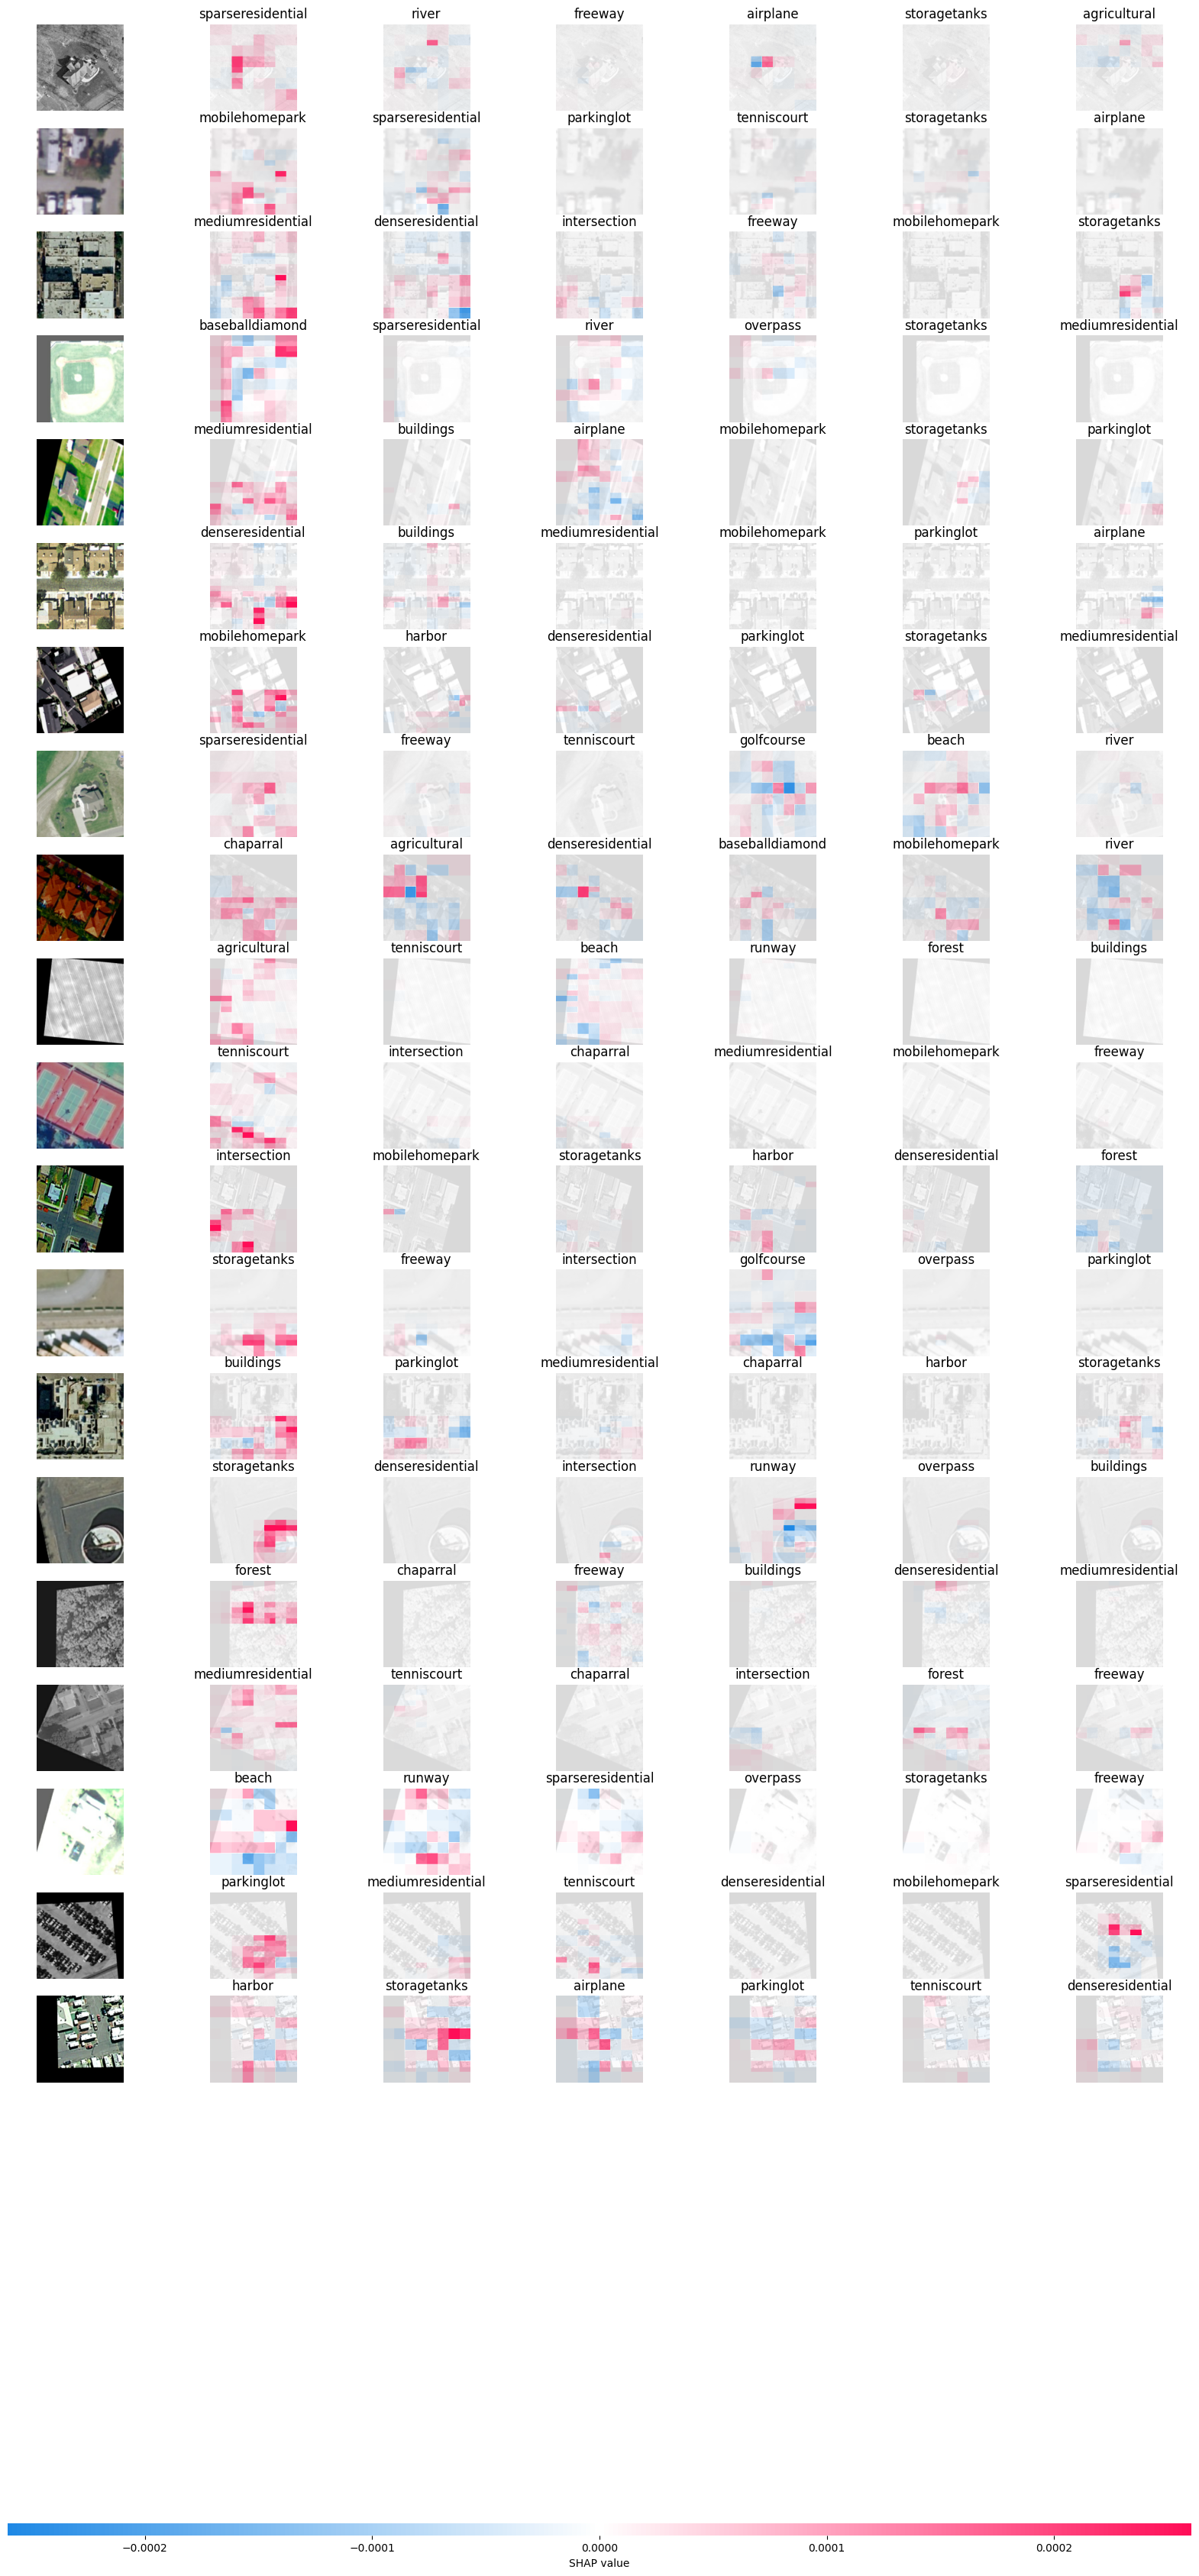

In [ ]:
# Convert the list of images to a numpy array
import shap
images_array = np.array(images_array)

shap_values = explainer(images_array, outputs=shap.Explanation.argsort.flip[:6])

shap_values.shape
shap.image_plot(shap_values)


GRADCAM EXPLAINER

In [ ]:
!pip install tensorflow matplotlib
!pip install gradcam
!pip install tf-explain


ERROR: Could not find a version that satisfies the requirement gradcam (from versions: none)
ERROR: No matching distribution found for gradcam
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.2 MB/s eta 0:00:00


First image to predict


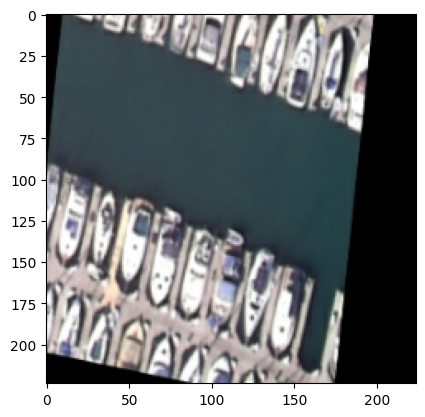

Actual label: harbor
1/1 [==============================] - 0s 41ms/step
Predicted label: harbor


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have defined your test dataset as test_data_s

# Get the first image and label from the test dataset
for images_batch, labels_batch in test_data_s.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("First image to predict")
    plt.imshow(first_image)
    plt.show()

    print("Actual label:", landuse_class_names[first_label])
    batch_prediction = model.predict(images_batch)
    print("Predicted label:", landuse_class_names[np.argmax(batch_prediction[0])])

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    predicted_class = landuse_class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)

    return predicted_class, confidence

# Assuming you have defined Disease_class_names elsewhere

In [ ]:
from tf_explain.core.grad_cam import GradCAM
import tensorflow as tf

# model = tf.keras.models.load_model('path_to_your_model.h5')

# Load a sample image (or
img = tf.keras.preprocessing.image.img_to_array(first_image)
data = ([img], None)

# Start explainer
explainer = GradCAM()
grid = explainer.explain(data, model, class_index=first_label, layer_name="res5a_branch2a")  # 281 is the tabby cat index in ImageNet

# Save the visualization
explainer.save(grid, ".", "grad_cam.png")

visualizing regions that contribute to the most specfic prediction

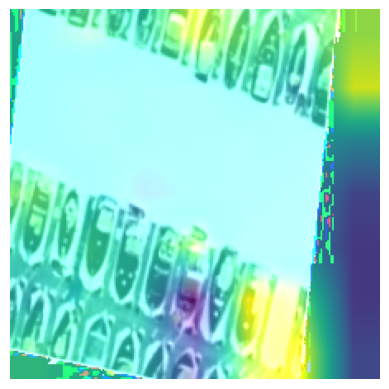

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Replace 'image_path' with the path to your saved GradCAM visualization image
image_path = "grad_cam.png"

# Load the image
img = mpimg.imread(image_path)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()
